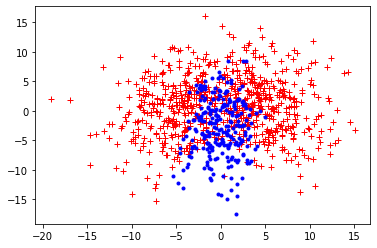

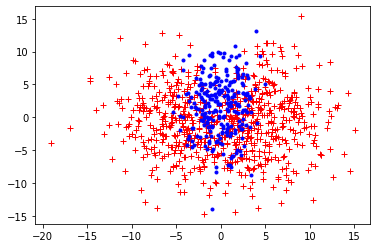

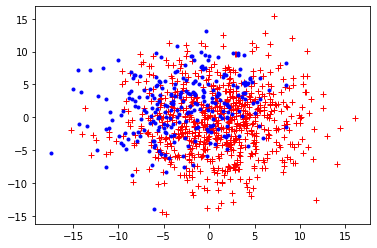

In [416]:
import numpy as np
import matplotlib.pyplot as plt

#sample
npoints=1000
#define points
x1 = np.random.normal(0, 5, npoints) #mean, sigma, num_points
x2 = np.random.normal(0, 5, npoints)
x3 = np.random.normal(0, 5, npoints)
x4 = np.random.normal(0, 5, npoints)

#make a discriminator between two samples that is largely y-based (small x-y slope)
mask_pos = x2 >  (3. - x1*x1+x3+x4)
mask_neg = x2 <= (3. - x1*x1+x3+x4)

#now smear
noise = 1.0 #sets the noise scale
x1noise = np.random.normal(0, noise, npoints)
x2noise = np.random.normal(0, noise, npoints)
x3noise = np.random.normal(0, noise, npoints)
x4noise = np.random.normal(0, noise, npoints)
x1 = x1 + x1noise
x2 = x2 + x2noise
x3 = x3 + x3noise
x4 = x4 + x3noise

# lets define a true boundary between the two classes
x1_pos = x1[mask_pos]
x2_pos = x2[mask_pos]
x3_pos = x3[mask_pos]
x4_pos = x4[mask_pos]
x1_neg = x1[mask_neg]
x2_neg = x2[mask_neg]
x3_neg = x3[mask_neg]
x4_neg = x4[mask_neg]

#plot the lot
plt.plot(x1_pos, x2_pos, 'r+')
plt.plot(x1_neg, x2_neg, 'b.')
x_list = [np.concatenate((x1_pos,x1_neg)),np.concatenate((x2_pos,x2_neg)),np.concatenate((x3_pos,x3_neg)),np.concatenate((x4_pos,x4_neg))]
y_list = [1.]*len(x1_pos) + [-1.]*len(x1_neg)
#y_list = [1.]*len(x1_pos) + [0]*len(x1_neg)
plt.show()

plt.plot(x1_pos, x3_pos, 'r+')
plt.plot(x1_neg, x3_neg, 'b.')
plt.show()

plt.plot(x2_pos, x3_pos, 'r+')
plt.plot(x2_neg, x3_neg, 'b.')
plt.show()

In [396]:
import torch 
import torch.nn as nn
from fast_soft_sort.pytorch_ops import soft_rank

class CorrLoss(nn.Module):
    def __init__(self, corr=False,sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        self.corr      = corr
        
    def spearman(self, pred, target):
        pred   = soft_rank(pred.reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(target.reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        #pred   = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        ret = (pred * target).sum()
        if self.corr:
            return (1-ret)*(1-ret)
        else:
            return ret*ret
    
    def forward(self, features, labels):
        return self.spearman(features,labels) 

class CorrLoss2(nn.Module):
    def __init__(self,background_only=False,background_label=1,power=2):
        self.backonly = background_only
        self.background_label = background_label
        self.power = power

    def distance_corr(self,var_1,var_2,normedweight,power=1):
        xx = var_1.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))
        #yy = var_1.            expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))
        amat = (xx).abs()
        del xx
        amatavg = torch.mean(amat*normedweight,dim=1)
        Amat=amat-amatavg.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))\
            -amatavg.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))\
            +torch.mean(amatavg*normedweight)
        del amat
        
        xx = var_2.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))
        #yy = var_2.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))
        bmat = (xx).abs()
        del xx

        bmatavg = torch.mean(bmat*normedweight,dim=1)
        Bmat=bmat-bmatavg.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))\
            -bmatavg.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))\
            +torch.mean(bmatavg*normedweight)
        del bmat

        ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
        AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
        BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)
        del Bmat, Amat

        if(power==1):
            dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
        elif(power==2):
            dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
        else:
            dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power

        return dCorr

    def __call__(self,pred,x_biased,weights=None):
        xweights = torch.ones_like(pred)
        disco = self.distance_corr(x_biased,pred,normedweight=xweights,power=self.power)
        return disco


    
#finally lets check it all
def compute_ROC(labels, predicts, npts=1001):
    lMin = np.min(predicts)
    lMax = np.max(predicts)
    cutvals = np.linspace(lMin,lMax,num=npts)
    tot0 = float(len(labels[labels==0]))
    tot1 = float(len(labels[labels==1]))
    tpr = []
    fpr = []
    for c in cutvals:
        fpr.append(float(len(predicts[(labels==0) & (predicts>c)]))/tot0)
        tpr.append(float(len(predicts[(labels==1) & (predicts>c)]))/tot1)
    
    return np.array(fpr),np.array(tpr)

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        #print((mask*log_prob).sum(1))
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()
        return loss
    
class BarlowTwinsLoss(torch.nn.Module):

    def __init__(self, lambda_param=5e-3):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param
        self.device = torch.device('cpu')

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        #self.device = (torch.device('cuda')if z_a.is_cuda else torch.device('cpu'))
        # normalize repr. along the batch dimension
        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0) # NxD
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0) # NxD

        N = z_a.size(0)
        D = z_a.size(1)

        # cross-correlation matrix
        c = torch.mm(z_a_norm.T, z_b_norm) / N # DxD
        # loss
        c_diff = (c - torch.eye(D,device=self.device)).pow(2) # DxD
        # multiply off-diagonal elems of c_diff by lambda
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
        loss = c_diff.sum()
        return loss
    
    #Phil Just implemented this, need to check all the math
    def forwardComplex(self, features, labels=None, mask=None):
        """Stealing above contrastive stuff"""
        device = (torch.device('cuda')if features.is_cuda else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        print(mask)
        #not sure what this is for
        N                 = features.shape[0] 
        contrast_count    = features.shape[1]
        contrast_feature  = torch.cat(torch.unbind(features, dim=1), dim=0)
        contrast_feature  = (contrast_feature - contrast_feature.mean(0)) / contrast_feature.std(0) 
        anchor_feature    = contrast_feature
        anchor_count      = contrast_count
 
        # compute logits
        c = torch.div(torch.mm(anchor_feature, contrast_feature.T), self.temperature)
        c_diff=(c - torch.eye(D,device=self.device)).pow(2)
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
    
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        logits = (c_diff * mask).sum(1)/ mask.sum(1)
        loss = loss.view(anchor_count, batch_size).mean()
        return loss

    

In [157]:
class simple_MLP(torch.nn.Module):
    def __init__(self,ninputs=4):
        super().__init__()
        self.fc1 = torch.nn.Linear(ninputs,16)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(16,1)
        self.output = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x
    

simple_model    = simple_MLP()
simple_model_n1 = simple_MLP(ninputs=3)

In [158]:
def makeTorchData(iList,iYList,iN=4,contrast=False):
    #formatting crap 
    if iN > 3:
        lx_list_np = np.transpose(np.vstack((iList[0],iList[1],iList[2],iList[3])))
    else:
        lx_list_np = np.transpose(np.vstack((iList[0],iList[2],iList[3])))
    ly_list_np = (np.array(iYList)+1)/2
    lx_torch=torch.from_numpy(lx_list_np).float()
    ly_torch=torch.from_numpy(ly_list_np.reshape(npoints,1)).float()
    if contrast:
        lx_torch=lx_torch.reshape(len(lx_torch),1,iN)
    return lx_torch,ly_torch

In [417]:
#Loss (Binary cross entry)
simple_criterion = torch.nn.BCELoss()
cor_criterion    = CorrLoss()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001) 
x_torch,y_torch  = makeTorchData(x_list,y_list)

for epoch in range(500):
    simple_optimizer.zero_grad()
    outputs = simple_model(x_torch)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))

outputs_optimal = simple_model(x_torch)
simple_model    = simple_MLP()
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01) 
for epoch in range(500):
    simple_optimizer.zero_grad()
    outputs     = simple_model(x_torch)
    loss_bce    = simple_criterion(outputs, y_torch)
    loss_corr   = cor_criterion(outputs,x_torch[:,1:2])    
    loss = loss_bce+10*loss_corr
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item(); corr_loss = loss_corr.item(); bce_loss = loss_bce.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f %.4f %.4f ' % (epoch + 1,  current_loss,corr_loss, bce_loss))

outputs_optimal_dec = simple_model(x_torch)
x_torch_n1,y_torch_n1  = makeTorchData(x_list,y_list,iN=2)
simple_optimizer = torch.optim.Adam(simple_model_n1.parameters(), lr=0.01) 
for epoch in range(500):
    simple_optimizer.zero_grad()
    outputs     = simple_model_n1(x_torch_n1)
    loss        = simple_criterion(outputs, y_torch_n1)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))

outputs_optimal_n1 = simple_model_n1(x_torch_n1)

[1] loss: 1.1923  
[51] loss: 0.7671  
[101] loss: 0.5373  
[151] loss: 0.4204  
[201] loss: 0.3587  
[251] loss: 0.3160  
[301] loss: 0.2781  
[351] loss: 0.2500  
[401] loss: 0.2321  
[451] loss: 0.2199  
[1] loss: 8.2563 0.7531 0.7254 
[51] loss: 0.7156 0.0014 0.7020 
[101] loss: 0.4760 0.0000 0.4759 
[151] loss: 0.4060 0.0001 0.4054 
[201] loss: 0.3672 0.0001 0.3662 
[251] loss: 0.3391 0.0001 0.3378 
[301] loss: 0.3201 0.0002 0.3185 
[351] loss: 0.3078 0.0002 0.3058 
[401] loss: 0.2994 0.0002 0.2970 
[451] loss: 0.2933 0.0003 0.2907 
[1] loss: 1.5413  
[51] loss: 0.3974  
[101] loss: 0.3234  
[151] loss: 0.3061  
[201] loss: 0.2988  
[251] loss: 0.2956  
[301] loss: 0.2931  
[351] loss: 0.2904  
[401] loss: 0.2886  
[451] loss: 0.2871  


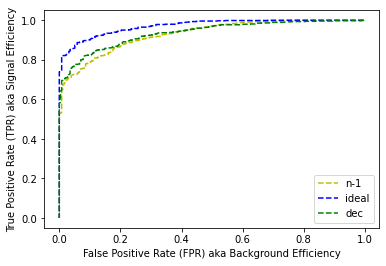

In [418]:
y_list_np = (np.array(y_list)+1)/2
roc_ideal          = compute_ROC(y_list_np,outputs_optimal_n1.detach().numpy().flatten())
roc_ideal_full     = compute_ROC(y_list_np,outputs_optimal.detach().numpy().flatten())
roc_ideal_fulldec  = compute_ROC(y_list_np,outputs_optimal_dec.detach().numpy().flatten())

plt.plot(roc_ideal[0],         roc_ideal[1],'y--',label="n-1")
plt.plot(roc_ideal_full[0],    roc_ideal_full[1],'b--',label="ideal")
plt.plot(roc_ideal_fulldec[0], roc_ideal_fulldec[1],'g--',label="dec")

plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

In [419]:
class test_CLR(torch.nn.Module):
    def __init__(self,ninputs=4):
        super().__init__()
        nhidden=16
        self.fc1 = torch.nn.Linear(ninputs,nhidden)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(nhidden,nhidden)
        self.ac2 = torch.nn.ReLU()
        #self.btchnorm = torch.nn.LazyBatchNorm1d()
        self.fc3 = torch.nn.Linear(nhidden,2)
        self.output = torch.nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        #x = self.btchnorm(x)
        x = self.fc3(x)
        #x = self.output(x)
        return x
    
test_clr        = test_CLR()
test_clr_dec    = test_CLR()
test_clr_n1     = simple_MLP(ninputs=2)
test_clr_n1_dec = simple_MLP(ninputs=2)

In [420]:
clr_criterion  = SupConLoss()
cor_criterion  = CorrLoss()
mse_criterion  = nn.MSELoss()
simple_criterion = torch.nn.BCELoss()
simple_optimizer = torch.optim.Adam(test_clr_dec.parameters(), lr=0.005) 
x_torch,y_torch  = makeTorchData(x_list,y_list,contrast=False)
x_torch_clr,y_torch_clr  = makeTorchData(x_list,y_list,contrast=True)
x_var =  np.sqrt(x_torch.var())

for epoch in range(500):
    simple_optimizer.zero_grad()
    outputs = test_clr_dec(x_torch_clr)
    loss_clr     = clr_criterion(outputs, y_torch_clr)
    loss_corr1   = cor_criterion(outputs[:,:,0:1],x_torch_clr[:,:,1:2])
    loss_corr2   = mse_criterion(x_torch_clr[:,:,1:2]/x_var,outputs[:,:,1:2])    
    #loss_corr2   = cor_criterion(outputs[:,:,0:1],outputs[:,:,1:2])    
    loss = loss_clr+loss_corr1+loss_corr2
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item(); corr_loss1 = loss_corr1.item(); corr_loss2 = loss_corr2.item(); clr_loss = loss_clr.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f %.4f %.4f %.4f ' % (epoch + 1,  current_loss,corr_loss1,corr_loss2, clr_loss))

with torch.no_grad():
    x_torch_clr_o_dec = (test_clr_dec(x_torch)).float()
simple_optimizer = torch.optim.Adam(test_clr_n1_dec.parameters(), lr=0.001)
for epoch in range(500):
    simple_optimizer.zero_grad()
    outputs=test_clr_n1_dec(x_torch_clr_o_dec)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    current_loss = loss.item()
    if epoch % 100 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))

outputs_optimal_clr_dec = test_clr_n1_dec(x_torch_clr_o_dec)

simple_optimizer = torch.optim.Adam(test_clr.parameters(), lr=0.001) 
for epoch in range(500):
    simple_optimizer.zero_grad()
    outputs  = test_clr(x_torch_clr)
    loss     = clr_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))

with torch.no_grad():
    x_torch_clr_o = (test_clr(x_torch)).float()
simple_optimizer = torch.optim.Adam(test_clr_n1.parameters(), lr=0.001)
for epoch in range(500):
    simple_optimizer.zero_grad()
    outputs=test_clr_n1(x_torch_clr_o)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    current_loss = loss.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))

outputs_optimal_clr = test_clr_n1(x_torch_clr_o)

[1] loss: 9.1528 0.0322 1.1884 7.9322 
[51] loss: 7.5900 0.0001 0.7211 6.8689 
[101] loss: 7.5169 0.0000 0.7146 6.8023 
[151] loss: 7.4608 0.0001 0.7036 6.7571 
[201] loss: 7.4238 0.0002 0.7002 6.7234 
[251] loss: 7.4084 0.0003 0.6979 6.7102 
[301] loss: 7.3963 0.0004 0.6954 6.7005 
[351] loss: 7.3891 0.0005 0.6946 6.6940 
[401] loss: 7.3839 0.0005 0.6947 6.6886 
[451] loss: 7.3800 0.0005 0.6953 6.6843 
[1] loss: 0.6510  
[101] loss: 0.5081  
[201] loss: 0.3854  
[301] loss: 0.2893  
[401] loss: 0.2270  
[1] loss: 11.6522  
[51] loss: 6.9335  
[101] loss: 6.9128  
[151] loss: 6.8954  
[201] loss: 6.8620  
[251] loss: 6.8150  
[301] loss: 6.7840  
[351] loss: 6.7683  
[401] loss: 6.7551  
[451] loss: 6.7411  
[1] loss: 0.7288  
[51] loss: 0.6666  
[101] loss: 0.6063  
[151] loss: 0.5434  
[201] loss: 0.4875  
[251] loss: 0.4436  
[301] loss: 0.4081  
[351] loss: 0.3764  
[401] loss: 0.3473  
[451] loss: 0.3213  


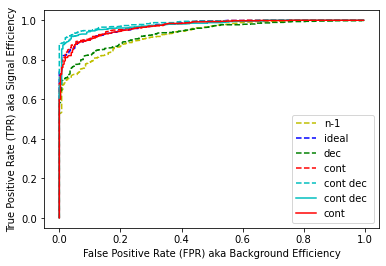

In [424]:
y_list_np = (np.array(y_list)+1)/2
roc_cont        = compute_ROC(y_list_np,outputs_optimal_clr.detach().numpy().flatten())
roc_contdec     = compute_ROC(y_list_np,outputs_optimal_clr_dec.detach().numpy().flatten())

roc_cont_0_dec  = compute_ROC(y_list_np,-1*x_torch_clr_o_dec[:,0].detach().numpy().flatten())
roc_cont_0      = compute_ROC(y_list_np,x_torch_clr_o    [:,0].detach().numpy().flatten())

#x_torch_clr_o_dec
plt.plot(roc_ideal[0],         roc_ideal[1],'y--',label="n-1")
plt.plot(roc_ideal_full[0],    roc_ideal_full[1],'b--',label="ideal")
plt.plot(roc_ideal_fulldec[0], roc_ideal_fulldec[1],'g--',label="dec")

plt.plot(roc_cont[0],    roc_cont[1],'r--',label="cont ")
plt.plot(roc_contdec[0], roc_contdec[1],'c--',label="cont dec")

plt.plot(roc_cont_0_dec[0],    roc_cont_0_dec[1],'c-',label="cont dec ")
plt.plot(roc_cont_0[0],        roc_cont_0[1],'r-',label="cont")

plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

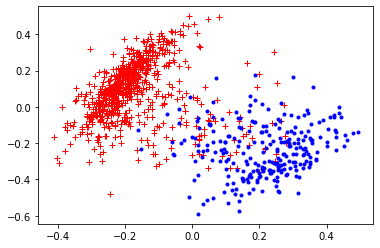

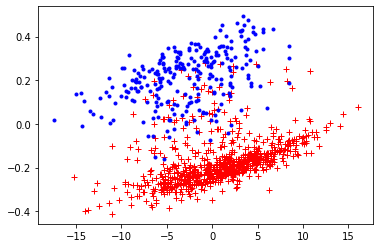

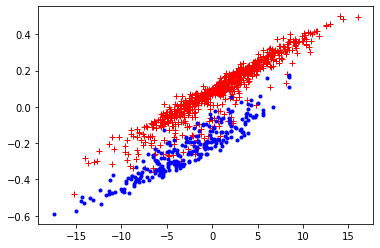

In [425]:
#This is the output space split by type
x_torch_clr_o_dec=test_clr_dec(x_torch_clr)
#print(x_torch_clr_o_dec[y_torch_clr > 0])
plt.plot(x_torch_clr_o_dec[y_torch > 0][:,0].detach().numpy(), x_torch_clr_o_dec[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(x_torch_clr_o_dec[y_torch == 0][:,0].detach().numpy(),x_torch_clr_o_dec[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should NOT be correlated
plt.plot(x_torch_clr[y_torch > 0][:,1].detach().numpy(),x_torch_clr_o_dec[y_torch > 0][:,0].detach().numpy(), 'k+',c='r')
plt.plot(x_torch_clr[y_torch == 0][:,1].detach().numpy(),x_torch_clr_o_dec[y_torch == 0][:,0].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should be correlated
plt.plot(x_torch_clr[y_torch > 0][:,1].detach().numpy(),x_torch_clr_o_dec[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(x_torch_clr[y_torch == 0][:,1].detach().numpy(),x_torch_clr_o_dec[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()

In [450]:
test_clr_bar    = test_CLR()
test_clr_bar_n1 = simple_MLP(ninputs=2)
clr_criterion  = BarlowTwinsLoss(lambda_param=1.0)
cor_criterion  = CorrLoss()
acr_criterion  = CorrLoss(corr=True)
mse_criterion  = nn.MSELoss()
simple_criterion = torch.nn.BCELoss()
simple_optimizer = torch.optim.Adam(test_clr_bar.parameters(), lr=0.001) 

x_torch,y_torch  = makeTorchData(x_list,y_list,contrast=False)
x_var =  np.sqrt(x_torch.var())
npos  = len(x1_pos); nneg = len(x_torch)-npos
for epoch in range(1000):
    r1=torch.cat((torch.randperm(npos),npos+torch.randperm(nneg)))
    r2=torch.cat((torch.randperm(npos),npos+torch.randperm(nneg)))
    x_train1=x_torch[r1]
    x_train2=x_torch[r2]
    simple_optimizer.zero_grad()
    outputs1     = test_clr_bar(x_train1)
    outputs2     = test_clr_bar(x_train2)
    loss_clr     = clr_criterion(outputs1,outputs2)
    loss_corr1   = cor_criterion(outputs1[:,0:1],x_train1[:,1:2])
    loss_corr2   = 100*acr_criterion(x_train1[:,1:2],outputs1[:,1:2])    
    #loss_corr2   = cor_criterion(outputs1[:,0:1],outputs1[:,1:2])    
    loss = loss_clr+loss_corr1+loss_corr2
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item(); corr_loss1 = loss_corr1.item(); corr_loss2 = loss_corr2.item(); clr_loss = loss_clr.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f %.4f %.4f %.4f ' % (epoch + 1,  current_loss,corr_loss1,corr_loss2, clr_loss))

with torch.no_grad():
    outputs_optimal_clr_bar = test_clr_bar(x_torch)
simple_optimizer = torch.optim.Adam(test_clr_bar_n1.parameters(), lr=0.001) 
for epoch in range(1000):
    simple_optimizer.zero_grad()
    outputs  = test_clr_bar_n1(outputs_optimal_clr_bar)
    loss     = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))

outputs_optimal_bar_dec = test_clr_bar_n1(outputs_optimal_clr_bar)

[1] loss: 117.5821 0.0040 115.7519 1.8262 
[51] loss: 5.0417 0.0059 3.1617 1.8742 
[101] loss: 2.8162 0.0192 1.0001 1.7969 
[151] loss: 2.0876 0.0210 0.4979 1.5686 
[201] loss: 1.8318 0.0169 0.2780 1.5370 
[251] loss: 1.7737 0.0169 0.1616 1.5952 
[301] loss: 1.5323 0.0219 0.1088 1.4015 
[351] loss: 1.5933 0.0223 0.0847 1.4863 
[401] loss: 1.4993 0.0223 0.0728 1.4042 
[451] loss: 1.4847 0.0270 0.0652 1.3925 
[501] loss: 1.5025 0.0268 0.0616 1.4141 
[551] loss: 1.4086 0.0164 0.0595 1.3327 
[601] loss: 1.5102 0.0266 0.0567 1.4269 
[651] loss: 1.4214 0.0175 0.0516 1.3523 
[701] loss: 1.2713 0.0224 0.0492 1.1997 
[751] loss: 1.3518 0.0204 0.0452 1.2861 
[801] loss: 1.3328 0.0164 0.0408 1.2756 
[851] loss: 1.3101 0.0162 0.0370 1.2568 
[901] loss: 1.1927 0.0147 0.0342 1.1437 
[951] loss: 1.2310 0.0155 0.0324 1.1830 
[1] loss: 0.7237  
[51] loss: 0.6396  
[101] loss: 0.5706  
[151] loss: 0.5102  
[201] loss: 0.4585  
[251] loss: 0.4169  
[301] loss: 0.3841  
[351] loss: 0.3575  
[401] loss: 0.

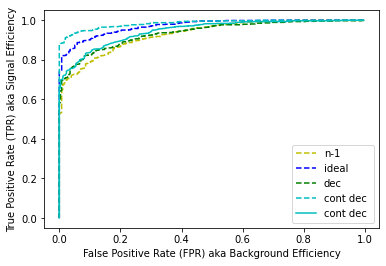

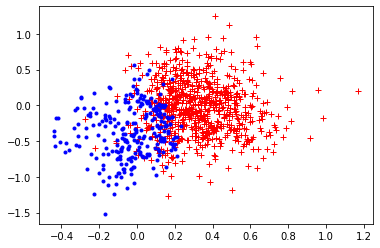

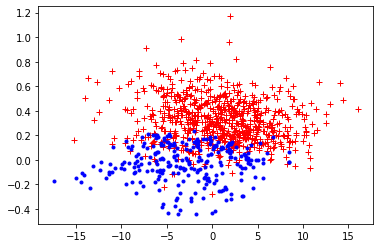

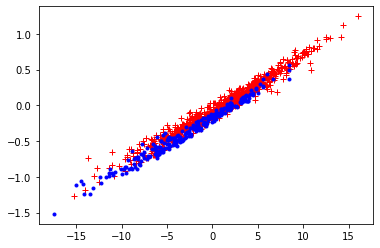

In [451]:
#all the performance stuff
y_list_np = (np.array(y_list)+1)/2
roc_cont_dec    = compute_ROC(y_list_np,outputs_optimal_bar_dec.detach().numpy().flatten())
roc_cont_0_dec  = compute_ROC(y_list_np,outputs_optimal_clr_bar[:,0].detach().numpy().flatten())

plt.plot(roc_ideal[0],         roc_ideal[1],'y--',label="n-1")
plt.plot(roc_ideal_full[0],    roc_ideal_full[1],'b--',label="ideal")
plt.plot(roc_ideal_fulldec[0], roc_ideal_fulldec[1],'g--',label="dec")

plt.plot(roc_contdec[0], roc_contdec[1],'c--',label="cont dec")
plt.plot(roc_cont_0_dec[0],    roc_cont_0_dec[1],'c-',label="cont dec ")

plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

x_torch_clr_o_bar=test_clr_bar(x_torch_clr)
plt.plot(x_torch_clr_o_bar[y_torch > 0][:,0].detach().numpy(), x_torch_clr_o_bar[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(x_torch_clr_o_bar[y_torch == 0][:,0].detach().numpy(),x_torch_clr_o_bar[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should NOT be correlated
plt.plot(x_torch_clr[y_torch > 0][:,1].detach().numpy(), x_torch_clr_o_bar[y_torch > 0][:,0].detach().numpy(), 'k+',c='r')
plt.plot(x_torch_clr[y_torch == 0][:,1].detach().numpy(),x_torch_clr_o_bar[y_torch == 0][:,0].detach().numpy(), 'k.',c='b')
plt.show()

#This plot should be correlated
plt.plot(x_torch_clr[y_torch > 0][:,1].detach().numpy(), x_torch_clr_o_bar[y_torch > 0][:,1].detach().numpy(), 'k+',c='r')
plt.plot(x_torch_clr[y_torch == 0][:,1].detach().numpy(),x_torch_clr_o_bar[y_torch == 0][:,1].detach().numpy(), 'k.',c='b')
plt.show()